In [41]:
from pathlib import Path
import os
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

In [4]:
os.chdir("../../")

In [42]:
repos = [
    "django",
    "pytest",
    "astropy",
    "scikit-learn",
    "sympy",
    "xarray",
    "requests",
    "matplotlib",
    "sphinx",
    "pylint",
    "flask",
    "seaborn",
]

In [43]:
result_dir = Path("report")

In [52]:
def convert_timestamp_to_quarter(timestamp):
    """
    Convert an ISO timestamp (e.g., '2018-06-23T05:35:26Z') to year and quarter format (e.g., '2018 Q2')
    
    Args:
        timestamp (str): ISO format timestamp
        
    Returns:
        str: Year and quarter in the format 'YYYY QN'
    """
    from datetime import datetime
    
    # Parse the timestamp
    date = datetime.fromisoformat(timestamp.replace('Z', '+00:00'))
    
    # Extract the year
    year = date.year
    
    # Get the month (1-indexed, January is 1)
    month = date.month
    
    # Determine the quarter
    if 1 <= month <= 3:
        quarter = 1
    elif 4 <= month <= 6:
        quarter = 2
    elif 7 <= month <= 9:
        quarter = 3
    else:  # 10-12
        quarter = 4
    
    # Return the formatted string
    return f"{year} Q{quarter}"

def convert_timestamp_to_year(timestamp):
    from datetime import datetime
    
    # Parse the timestamp
    date = datetime.fromisoformat(timestamp.replace('Z', '+00:00'))
    
    # Extract the year
    year = date.year
    return year

stats = []
for r in repos:
    for instance_run in os.listdir(result_dir / r):
        instance_path = result_dir / r / instance_run
        if os.path.isfile(instance_path / "FINAL_STATUS"):
            example = pkl.load(open(instance_path / "example.pkl", "rb"))
            with open(instance_path / "FINAL_STATUS", "r") as f:
                stats.append((
                    r,
                    instance_run,
                    f.read(),
                    convert_timestamp_to_year(example["created_at"])
                ))

In [62]:
stats_df = pd.DataFrame(stats, columns=["repo", "instance", "status", "year"])
summary = stats_df.groupby("repo")["status"].value_counts().unstack(fill_value=0)
# Add total column
summary["total"] = summary.sum(axis=1)
summary['resolve_pct'] = (summary['RESOLVED'] / summary['total'] * 100).round(2)
avg_resolve_pct = summary['resolve_pct'].mean()

summary = summary.reset_index()

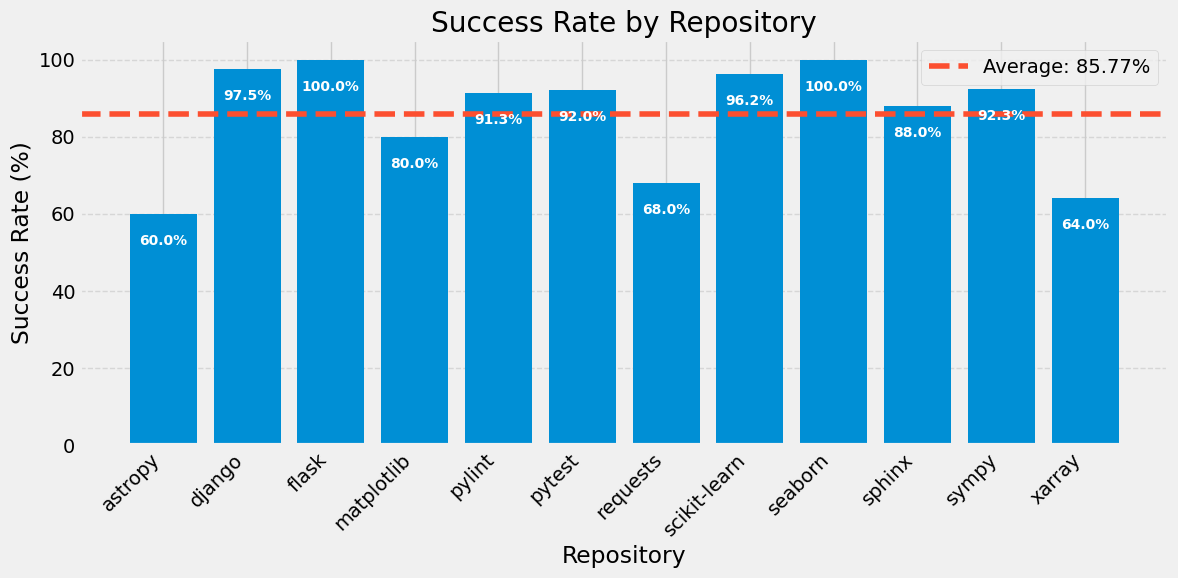

<Figure size 640x480 with 0 Axes>

In [66]:
# Set up the FiveThirtyEight style
plt.style.use('fivethirtyeight')

fivethirtyeight_red = '#fc4f30'

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(summary['repo'], summary['resolve_pct'])

# Add the horizontal line for average
plt.axhline(y=avg_resolve_pct, color= fivethirtyeight_red,linestyle='--', 
            label=f'Average: {avg_resolve_pct:.2f}%')

# Add percentage values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 7,  # Position inside the bar
             f'{height:.1f}%', ha='center', va='center', 
             color='white', fontweight='bold', fontsize=10)

# Add labels and title
plt.xlabel('Repository')
plt.ylabel('Success Rate (%)')
plt.title('Success Rate by Repository')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
plt.savefig("by_repo.png", dpi=300)

In [67]:
stats_df = pd.DataFrame(stats, columns=["repo", "instance", "status", "year"])
summary = stats_df.groupby("year")["status"].value_counts().unstack(fill_value=0)
# Add total column
summary["total"] = summary.sum(axis=1)
summary['resolve_pct'] = (summary['RESOLVED'] / summary['total'] * 100).round(2)
avg_resolve_pct = summary['resolve_pct'].mean()

summary = summary.reset_index()

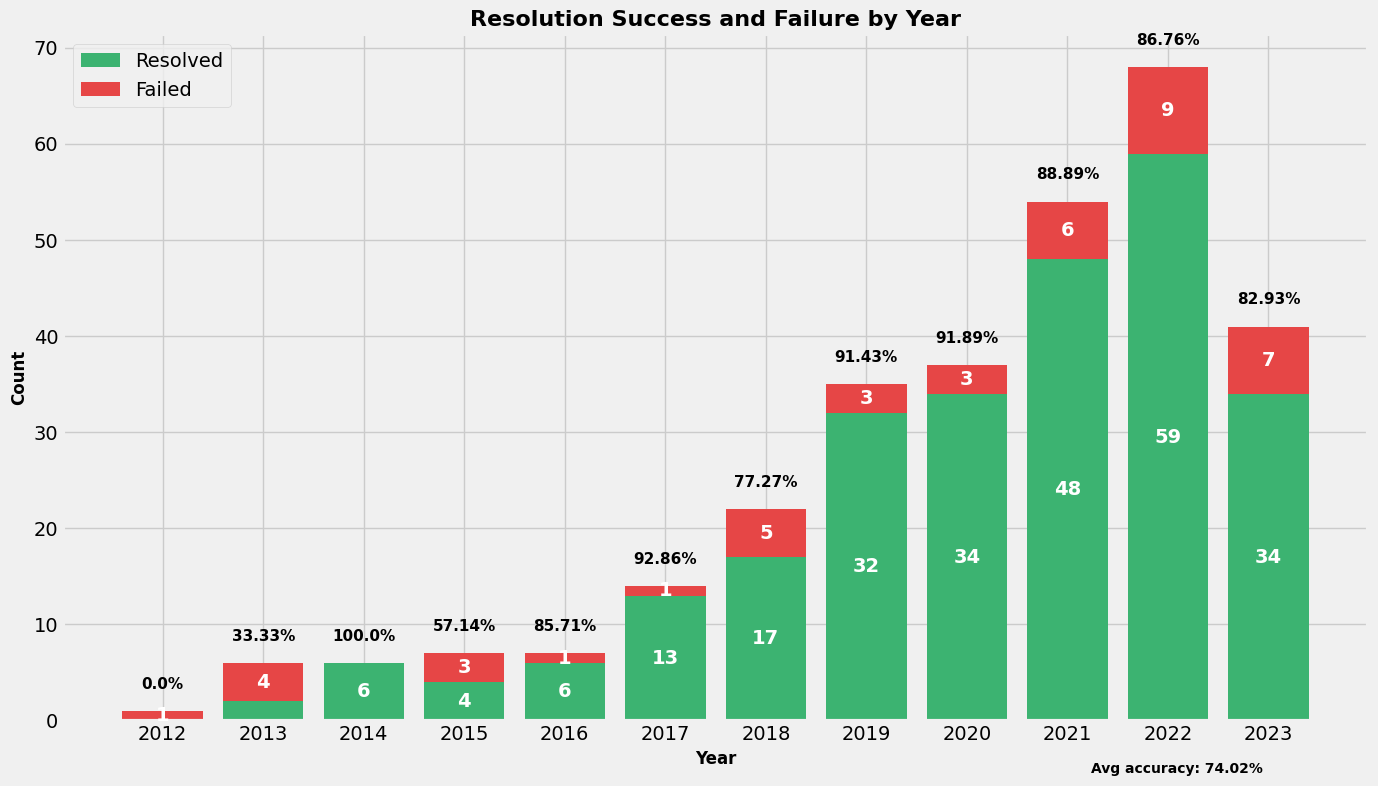

<Figure size 640x480 with 0 Axes>

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up the FiveThirtyEight style
plt.style.use('fivethirtyeight')

# Create the figure with the desired size
plt.figure(figsize=(14, 8))

# Calculate success and failure counts for each year
success_counts = summary['RESOLVED'].values
failure_counts = summary['EXCEPTION'] + summary['FAILURE'] + summary['TIMEOUT']
years = summary['year'].values

# Create the stacked bar chart
bar_width = 0.8
x = np.arange(len(years))

# Plot the success bars at the bottom (in green)
success_bars = plt.bar(x, success_counts, bar_width, color='#3CB371', label='Resolved')

# Plot the failure bars on top (in red)
failure_bars = plt.bar(x, failure_counts, bar_width, bottom=success_counts, 
                       color='#E64646', label='Failed')

# Add the percentage labels on top of each bar
for i in range(len(x)):
    # Get total height for each stacked bar
    total_height = success_counts[i] + failure_counts[i]
    
    # Add the percentage text on top of each bar
    plt.text(x[i], total_height + 2, f"{summary['resolve_pct'][i]}%", 
             ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Add count labels inside each part of the stacked bar if there's enough space
    if success_counts[i] > 3:
        plt.text(x[i], success_counts[i]/2, f"{int(success_counts[i])}", 
                 ha='center', va='center', color='white', fontweight='bold')
    
    if failure_counts[i] > 0:
        plt.text(x[i], success_counts[i] + failure_counts[i]/2, f"{int(failure_counts[i])}", 
                 ha='center', va='center', color='white', fontweight='bold')

# Add labels and title
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Resolution Success and Failure by Year', fontsize=16, fontweight='bold')

# Set the x-ticks to the years
plt.xticks(x, years, rotation=0)

# Add a legend
plt.legend(loc='upper left')

# Add text annotation for average
plt.figtext(0.91, 0.02, f'Avg accuracy: {avg_resolve_pct:.2f}%', 
            ha='right', fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig("by_year.png", dpi=300)